In [51]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

# Convolutional Neural Network
## CIFAR-10 Image Classification
### 1. Loading the dataset

In image preprocessing, the data is first **normalized** to improve model performance and convergence during training. Normalization typically involves adjusting the pixel values so that they have a consistent scale, often by rescaling them to have a specific mean and standard deviation. 

In this case, the pixel values are transformed such that the mean of the dataset is subtracted from each pixel value, followed by dividing by the standard deviation. This results in pixel values being centered around zero with a unit variance. The formula for this is:

$$
\text{Normalized Value} = \frac{\text{Original Value} - \text{Mean}}{\text{Standard Deviation}}
$$

This normalization helps in speeding up the training process. For images, mean and standard deviation values can either be calculated from the dataset or set to widely-used defaults (e.g., for images in the RGB range, mean values of [0.485, 0.456, 0.406] and standard deviations of [0.229, 0.224, 0.225] are often used for datasets like ImageNet).

```python
# if you get ssh error, try following
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context
```

In [52]:
torch.manual_seed(0)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(
                                           mean=(0.5, 0.5, 0.5), 
                                           std=(0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(
    root='~/Downloads/dataset/',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root='~/Downloads/dataset/',
    train=False,
    download=True,
    transform=transform
)

batchsize = 64
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


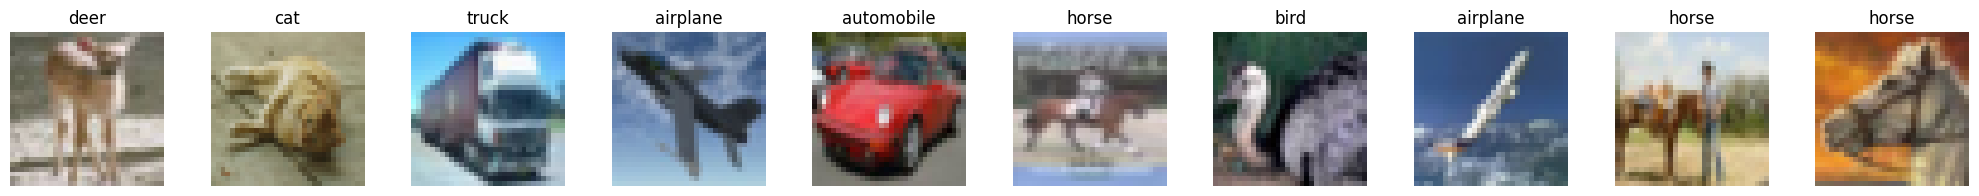

In [53]:
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.),(2.,2.,2.)), 
                            transforms.ToPILImage()])


images, labels =  next(iter(trainloader))

idx_to_class = {value: key for key, value in trainset.class_to_idx.items()}

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[labels[i].item()])
plt.show()


### 2. Build a convolutional neural network (CNN) for classification

In [54]:
device = torch.device('mps')
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MyFirstCnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1), # output: 4x32x32
            nn.ReLU(),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1), # output: 8X32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # output: 8x8x8

            nn.Flatten(), 
            nn.Linear(8*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )    


        
        self.network2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # output: 32x32x32
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # output: 64X32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64x16x16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # output: 128x16x16
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # output: 128x16x16
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128x8x8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # output: 256x8x8
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # output: 256x8x8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256x4x4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)                         
        )
    def forward(self, x):
        # network 1 is small and will train quickly but accurcy will be low
        #
        return self.network1(x)


In [14]:
model = MyFirstCnnModel()
model.to(device)
print(model)

MyFirstCnnModel(
  (network1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
  (network2): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, 

### 3. Train the network 

In [56]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train_history = []
val_history = []

In [ ]:
# Training loop
model.train() # tell the model that your are trainin the model
for epoch in range(10):
    train_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        outputs = model(inputs)
        
        loss = criteria(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()

    # validation
    with torch.no_grad():
        val_loss = 0
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()
            
    print(f'Epoch [{epoch}], train loss: {train_loss/len(trainset)}, val loss: {val_loss/len(testset)}')        
    train_history += [train_loss/len(trainset)]
    val_history += [val_loss/len(testset)]
print("Finished Training")

Epoch [0], train loss: 0.01645783452987671, val loss: 0.016820761787891388


### 4. Plot Convergence plot

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b')
plt.plot(val_history, 'r')
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend('train loss', 'val loss')
plt.show()

### 5. Validate on test set

In [ ]:
import torchvision

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)
    
outputs = model(images)
_, predicted = torch.max(outputs, dim=1)

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f"Actual {idx_to_class[labels[i].item()]}\tPredicted: {idx_to_class[predicted[i].item()]}")
plt.show()



In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %%')


Accuracy of the network on the 10000 test images: 66.14 %%
